<a href="https://colab.research.google.com/github/katherina-jiawen/InClassEcon441B/blob/main/Week_7_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.) Import an asset price from Yahoo Finance

In [3]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout


########################################
####Pick your ticker and time period####
########################################
stock_data = yf.download("AAPL", start="1990-01-01", end="2022-02-21")



# Preprocess data
scaled_data = np.array(stock_data["Close"].pct_change().dropna()).reshape(-1,1)


# Split data into training and test sets
training_data_len = int(len(scaled_data) * 0.8)
train_data = scaled_data[0:training_data_len, :]



[*********************100%***********************]  1 of 1 completed


# 2.) Create your x_train/y_train data so that your RNN uses percentage change data to make a binary forecast where the stock moves up or down the next day
# Build an RNN Architecture accordingly

In [22]:
x_train = []
y_train = []


#############################################################
####Pick your input size and edit to make binary forecast####
#############################################################
input_size = 3
for i in range(input_size, len(train_data)):
    x_train.append(train_data[i-input_size:i, 0])
    y_train.append(train_data[i, 0]) # if y_train(i) > 0 --> 1
                                     # elif y_train(i) < 0 --> 0

# Reshape your data 
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

###################################
####Build Your RNN Architecture####
###################################
model = Sequential()
model.add(LSTM(x_train.shape[1], return_sequences=True, input_shape=(x_train.shape[1], 1)))
#Examples
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25)) # dropout percentage 
# Classification : pick your activiation function 
model.add(Dense(1))




model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=1, epochs=3)

Epoch 1/3
6474/6474 [==============================] - 42s 6ms/step - loss: 8.8527e-04
Epoch 2/3
6474/6474 [==============================] - 34s 5ms/step - loss: 8.7514e-04
Epoch 3/3
6474/6474 [==============================] - 35s 5ms/step - loss: 8.7542e-04


# 3.) Test your model and compare insample Accurracy, insample random walk assumption Accuracy, Out of sample Accuracy and out of sample random walk assumption Accuracy using a bar chart

In [23]:

test_data = scaled_data[training_data_len - input_size:, :]

x_test = []
y_test = np.array(stock_data[["Close"]].pct_change().dropna())[training_data_len:, :]
for i in range(input_size, len(test_data)):
    x_test.append(test_data[i-input_size:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))




predictions = model.predict(x_test)



51/51 [==============================] - 2s 3ms/step


In [11]:
# IN Random Walk Model
y_train[1:] #Actual 
y_train[:-1] #Prediction

#OOS Random Walk Model
y_test[1:] #Actual
y_test[:-1] #Prediction

array([[ 0.00111803],
       [-0.02138996],
       [-0.00412571],
       ...,
       [ 0.02315247],
       [-0.00138891],
       [-0.02126919]])

In [25]:
from sklearn.metrics import mean_squared_error
in_sample_mse = mean_squared_error(y_train, model.predict(x_train))
in_sample_mse_rm = mean_squared_error(y_train[1:], y_train[:-1])
out_of_sample_mse = mean_squared_error(y_test, model.predict(x_test))
out_sample_mse_rm  = mean_squared_error(y_test[1:], y_test[:-1])

print("In-sample MSE: ", in_sample_mse)
print("Out-of-sample MSE: ", out_of_sample_mse)
print("In-sample-RandomWalk MSE: ", in_sample_mse_rm)
print("Out-of-sample-RandomWalk MSE: ", out_sample_mse_rm)

51/51 [==============================] - 0s 3ms/step
In-sample MSE:  0.0008640364147976497
Out-of-sample MSE:  0.000343646624400103
In-sample-RandomWalk MSE:  0.001734076649970463
Out-of-sample-RandomWalk MSE:  0.0007444356704660789


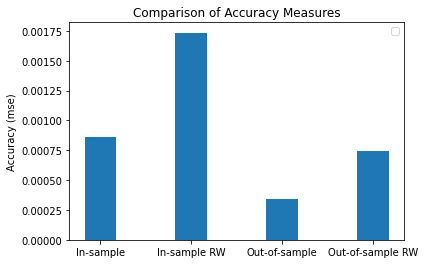

In [27]:
import matplotlib.pyplot as plt
import numpy as np



# Create a bar chart with four bars
labels = ['In-sample', 'In-sample RW', 'Out-of-sample', 'Out-of-sample RW']
accuracy_measures = [in_sample_mse, in_sample_mse_rm, out_of_sample_mse, out_sample_mse_rm]
x = np.arange(len(labels))
width = 0.35
fig, ax = plt.subplots()
rects = ax.bar(x, accuracy_measures, width)

# Add labels, title, and legend
ax.set_ylabel('Accuracy (mse)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_title('Comparison of Accuracy Measures')
ax.legend()

# Display the chart
plt.show()

(DON'T DO)# 4.) Plot in and out of sample accuracy

In [ ]:
import matplotlib.pyplot as plt

# Make predictions on full dataset

test_predict = model.predict(x_test)
test_predictions = (test_predict+1).reshape(1,-1) * np.cumprod(y_test+1)

train_predict = model.predict(x_train)
train_predictions = (train_predict+1).reshape(1,-1) * np.cumprod(y_train+1)



plt.plot(stock_data[:training_data_len- input_size].index, np.cumprod(y_train+1), label="Training Data")
plt.plot(stock_data[:training_data_len- input_size].index, train_predictions[0], label="Training Predictions")
end_val = np.cumprod(y_train+1)[-1]
test_predict = model.predict(x_test)
test_predictions = (test_predict+1).reshape(1,-1) * (np.cumprod((y_test+1))*end_val)
plt.plot(stock_data[training_data_len+1:].index, np.cumprod((y_test+1))*end_val,label="Test Data")
plt.plot(stock_data[training_data_len+1:].index, test_predictions[0], label="Test Predictions")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

#5.) Write an observation/conclusion about the graphs from Q4 and Q3

The accuracy of random walk is way higher than the model, it means the model failed to predict and needs improvements. 

# 6.) Create a parameter for number of lags in your input layer. Do a 3-fold CV to test three different time lags. i.e. Tested using 5,10,20 days of previous price data to forecast

In [28]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.wrappers.scikit_learn import KerasRegressor

# Define the Keras model
###Edit here to create your optimizer
def create_model():
    model = Sequential()
    model.add(Dense(10, input_dim=60, activation='LSTM'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return(model)

# Wrap the Keras model in a scikit-learn compatible estimator
model = KerasRegressor(build_fn=create_model, verbose=0)

# Define the hyperparameters to search over
####EXAMPLE###
#param_grid = {'batch_size': [10, 20, 100],
#              'epochs': [10, 100],
#              'neurons':[5,10,20]}

# Perform the grid search over the hyperparameters

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(x_train, y_train)

# Print the results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

<ipython-input-28-0ea12003301b>:15: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


NameError: ignored